In [20]:
import jax
import matplotlib.pyplot as plt
import numpy as np
from models import CatCNOT, CrossResonanceGate

import dynamiqs as dq


def is_gpu_available() -> bool:
    return any('cuda' in str(device) for device in jax.devices())

In [21]:
# init models
models = {
    'crgate': CrossResonanceGate(),
    'catcnot16': CatCNOT(N=16),
    'catcnot32': CatCNOT(N=32)
}

# compute speedups for each model
speedups = {}
for label, model in models.items():
    print(f'Running benchmark for {label}')  # noqa: T201

    # compile the dynamiqs model
    model.run_dynamiqs()

    # benchmark models
    dq.set_device('cpu')
    timer_qutip_cpu = %timeit -o -r 1 model.run_qutip()
    timer_dynamiqs_cpu = %timeit -o -r 1 model.run_dynamiqs()
    if is_gpu_available():
        dq.set_device('gpu')
        timer_dynamiqs_gpu = %timeit -o -r 1 model.run_dynamiqs()

    # store results
    speedup_cpu = timer_qutip_cpu.average / timer_dynamiqs_cpu.average
    if is_gpu_available():
        speedup_gpu = timer_qutip_cpu.average / timer_dynamiqs_gpu.average
        speedups[label] = (1.0, speedup_cpu, speedup_gpu)
    else:
        speedups[label] = (1.0, speedup_cpu)

Running benchmark for crgate
2.96 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
2.19 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
47.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Running benchmark for catcnot16
1.98 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
702 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
35 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
Running benchmark for catcnot32
1min 30s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2min 1s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.79 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


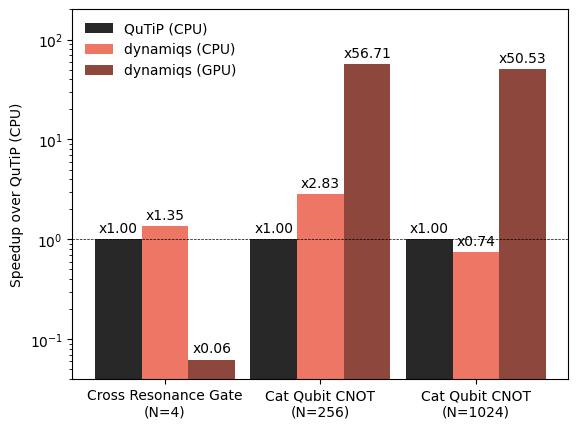

In [31]:
# prepare plot formatting
model_labels = {
    'crgate': 'Cross Resonance Gate\n(N=4)',
    'catcnot16': 'Cat Qubit CNOT\n(N=256)',
    'catcnot32': 'Cat Qubit CNOT\n(N=1024)',
}
groups = np.arange(len(models))
colors = ['#282828', '#ed7764']
labels = ['QuTiP (CPU)', 'dynamiqs (CPU)']
if is_gpu_available():
    labels.append('dynamiqs (GPU)')
    colors.append('#8e473c')
    width = 0.3
else:
    width = 0.45

# create plot
fig, ax = plt.subplots()
ax.axhline(1.0, 0, len(models), color='k', linestyle='--', lw=0.5)

for i, label in enumerate(labels):
    offset = i * width
    speedup = [speedups[model][i] for model in models]
    rects = ax.bar(groups + offset, speedup, width, color=colors[i], label=label)
    ax.bar_label(rects, padding=3, fmt='x%.2f')

ax.legend(frameon=False)
ax.set_ylabel('Speedup over QuTiP (CPU)')
ax.set_xticks(groups + width, list(model_labels.values()))
ax.set_yscale('log')
ax.set_ylim((0.04, 200))
plt.show()